In [20]:
import pandas as pd

# 1. CSV-Dateien einlesen
Broadband_Access = pd.read_csv("/Users/calvin/Documents/R/Broadband_Access.csv", header=0, sep=",", decimal=",")
Household_Spending = pd.read_csv("/Users/calvin/Documents/R/Household_Spending.csv", header=0, sep=",", decimal=",")
Population = pd.read_csv("/Users/calvin/Documents/R/Population.csv", header=0, sep=",", decimal=",")
Haushaltsgroeße = pd.read_csv("/Users/calvin/Documents/R/Haushaltsgroeße.csv", header=0, sep=",", decimal=",")


# 2. Relevante Spalten aus den Datensätzen extrahieren
Household_Spending = Household_Spending[["Country", "TIME_PERIOD", "OBS_VALUE"]]
Broadband_Access = Broadband_Access[["Reference area", "TIME_PERIOD", "OBS_VALUE"]]
Population = Population[["Country Name"] + [str(year) for year in range(2011, 2021)]]
Haushaltsgroeße = Haushaltsgroeße[["Geopolitical entity (reporting)", "TIME_PERIOD", "OBS_VALUE"]]

# 3. Spaltennamen vereinheitlichen
Household_Spending.columns = ["Country", "Year", "Total_Spending"]
Broadband_Access.columns = ["Country", "Year", "Percentage_Households"]
Population.columns = ["Country" if x == "Country Name" else x for x in Population.columns]
Haushaltsgroeße.columns = ["Country", "Year", "household_size"]

# 4. Bevölkerungsdaten ins Long-Format transformieren
Population = Population.melt(id_vars=["Country"], var_name="Year", value_name="Total_Population")

# 5. Datentypen anpassen
Household_Spending["Total_Spending"] = pd.to_numeric(Household_Spending["Total_Spending"], errors='coerce')
Broadband_Access["Percentage_Households"] = pd.to_numeric(Broadband_Access["Percentage_Households"], errors='coerce')
Population["Year"] = Population["Year"].astype(int)
Population["Total_Population"] = pd.to_numeric(Population["Total_Population"], errors='coerce')

# 6. Uneinheitliche Ländernamen harmonisieren
Population["Country"] = Population["Country"].str.replace("Turkiye", "Türkiye")
Population["Country"] = Population["Country"].str.replace("Russian Federation", "Russia")
Household_Spending["Country"] = Household_Spending["Country"].str.replace("Korea, Rep.", "Korea")
Household_Spending["Country"] = Household_Spending["Country"].str.replace("China \\(People's Republic of\\)", "China")

# 7. Aggregierte Regionen aus Haushaltsausgaben-Daten entfernen
Household_Spending = Household_Spending[~Household_Spending["Country"].isin(["Euro area", "European Union"])]

# 8. Länder mit vollständiger Zeitreihe (2011–2020) auswählen und Daten filtern
all_years = pd.DataFrame({"Year": range(2011, 2021)})
countries = Broadband_Access["Country"].unique()
all_combinations = pd.MultiIndex.from_product([countries, range(2011, 2021)], names=["Country", "Year"]).to_frame(index=False)
Broadband_Access_full = pd.merge(all_combinations, Broadband_Access, on=["Country", "Year"], how="left")
completeness = Broadband_Access_full.groupby("Country")["Percentage_Households"].apply(lambda x: x.notna().mean())
valid_countries = completeness[completeness >= 0.9].index
Broadband_Access_90 = Broadband_Access_full[Broadband_Access_full["Country"].isin(valid_countries)]

# 9. Haushaltssausgaben-Daten mit Bevölkerungszahlen zusammenführen
Household_Spending = pd.merge(Household_Spending, Population, on=["Country", "Year"])

# 10. Pro-Kopf-Ausgaben berechnen (USD)
# Stelle sicher, dass beide Spalten numerisch sind und keine fehlenden Werte haben
Household_Spending["Total_Spending"] = pd.to_numeric(Household_Spending["Total_Spending"], errors='coerce')
Household_Spending["Total_Population"] = pd.to_numeric(Household_Spending["Total_Population"], errors='coerce')

# Berechne Pro-Kopf-Ausgaben nur für Zeilen mit gültigen Werten
Household_Spending["Capita_Spending"] = (
    Household_Spending["Total_Spending"] * 1e6
) / Household_Spending["Total_Population"]



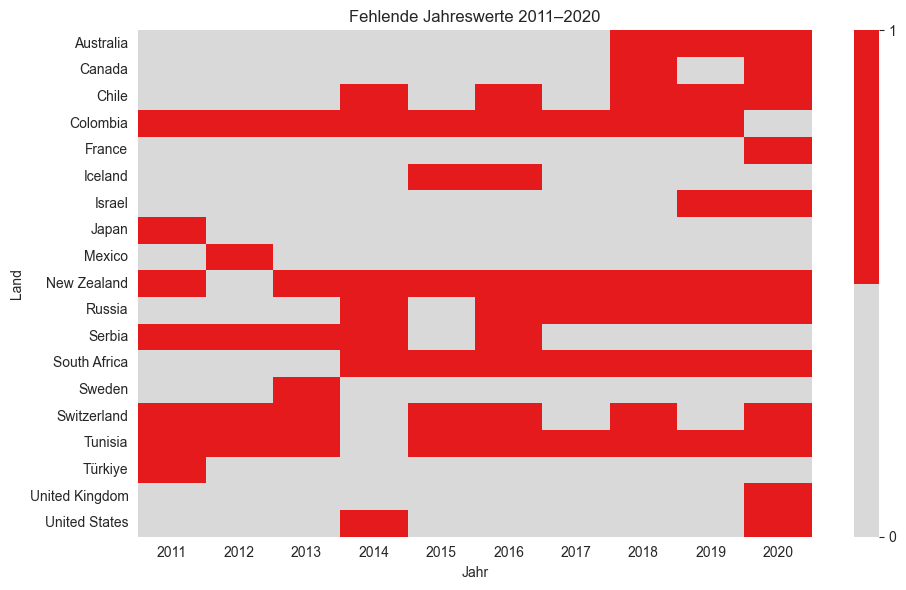

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Unvollständige Breitbanddaten identifizieren
all_years = pd.DataFrame({"Year": range(2011, 2021)})
countries = Broadband_Access["Country"].unique()
all_combinations = pd.MultiIndex.from_product([countries, range(2011, 2021)], names=["Country", "Year"]).to_frame(index=False)

# Merge mit den ursprünglichen Daten
Broadband_Access_full = pd.merge(all_combinations, Broadband_Access, on=["Country", "Year"], how="left")

# Berechnung der Anzahl der verfügbaren Jahre pro Land
years_available = Broadband_Access_full.groupby("Country")["Percentage_Households"].apply(lambda x: x.notna().sum()).reset_index()
years_available.columns = ["Country", "years_available"]

# Filtere Länder mit unvollständigen Daten
Unvollständig_Breitband = years_available[years_available["years_available"] < len(range(2011, 2021))]
Unvollständig_Breitband = Unvollständig_Breitband.sort_values(by="years_available", ascending=False)

# Fehlende Werte visualisieren (Heatmap)
missing_map = pd.merge(all_combinations, Broadband_Access, on=["Country", "Year"], how="left")
missing_map["any_missing"] = missing_map["Percentage_Households"].isna().astype(int)
missing_map = missing_map[missing_map["Country"].isin(Unvollständig_Breitband["Country"])]
missing_map = missing_map[["Country", "Year", "any_missing"]]

# Pivotiere die Daten für die Heatmap
missing_map_pivot = missing_map.pivot(index="Country", columns="Year", values="any_missing")

# Heatmap der fehlenden Werte
plt.figure(figsize=(10, 6))
sns.heatmap(
    missing_map_pivot,
    cmap=["#d9d9d9", "#e41a1c"],
    cbar_kws={"ticks": [0, 1], "label": ""},
    xticklabels=missing_map_pivot.columns,
    yticklabels=True
)
plt.title("Fehlende Jahreswerte 2011–2020")
plt.xlabel("Jahr")
plt.ylabel("Land")
plt.tight_layout()
plt.show()


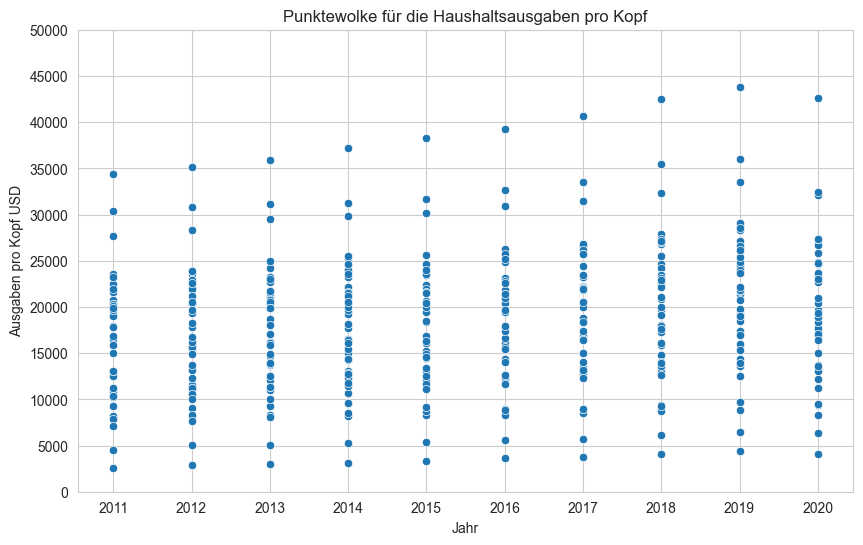

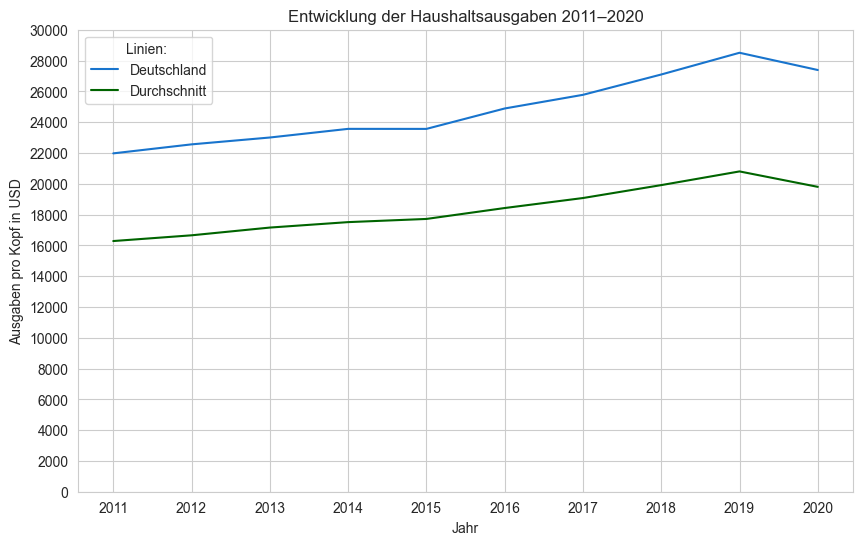

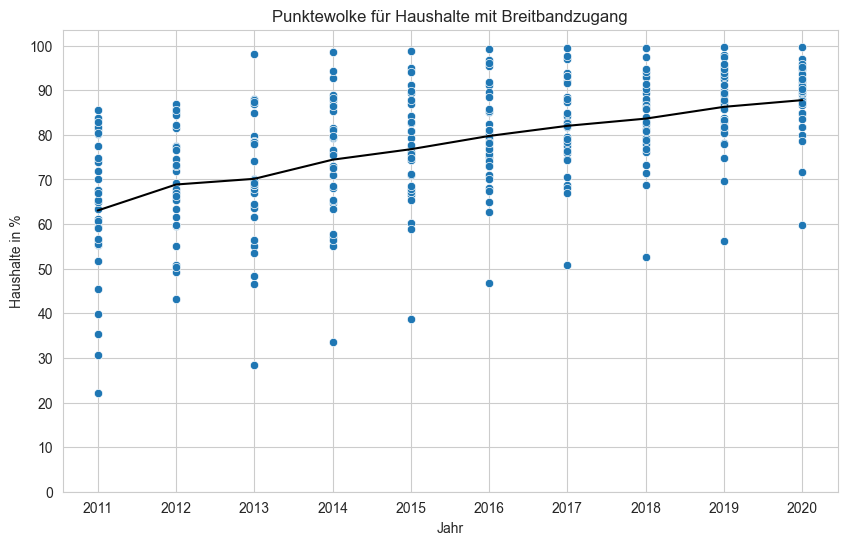

Korrelation: 0.6696023445259232, p-Wert: 3.1391370495796295e-06


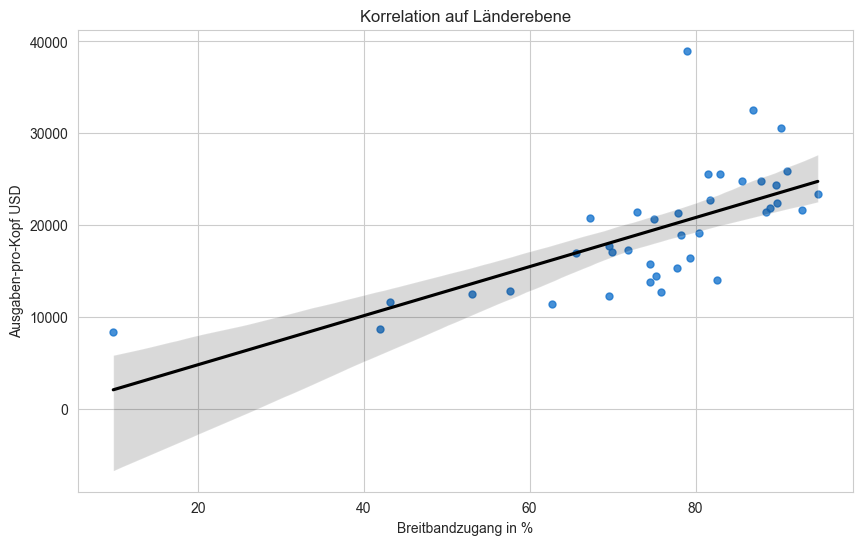

/var/folders/tt/17l24mc97qn4rv53m2c8v5wm0000gn/T/ipykernel_8899/1891190491.py:69: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  Household_cor_by_Land = Household_Spending.groupby("Country").apply(lambda x: x[["Capita_Spending", "Year"]].corr().iloc[0, 1]).reset_index()
/var/folders/tt/17l24mc97qn4rv53m2c8v5wm0000gn/T/ipykernel_8899/1891190491.py:72: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  Broadband_cor_by_Land 

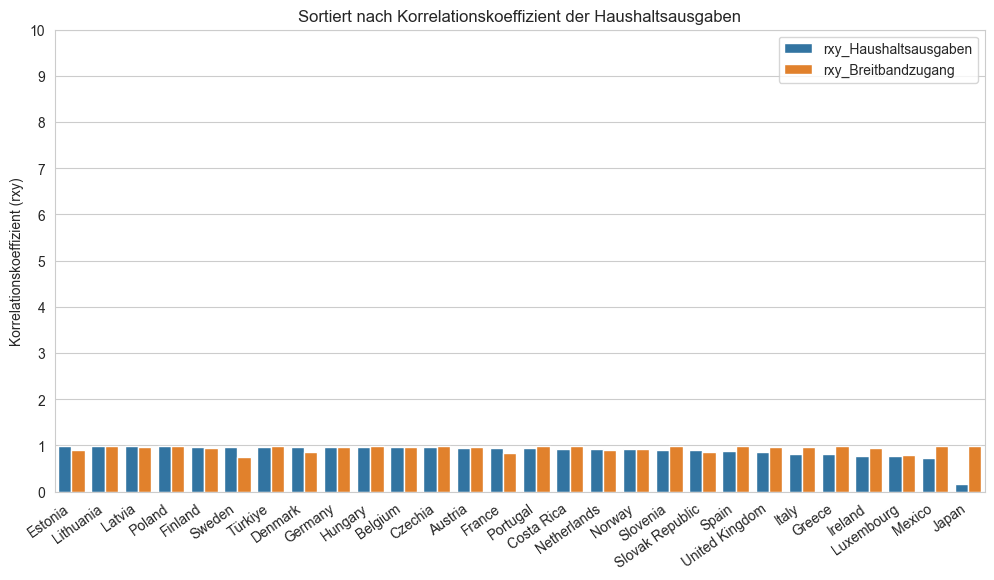

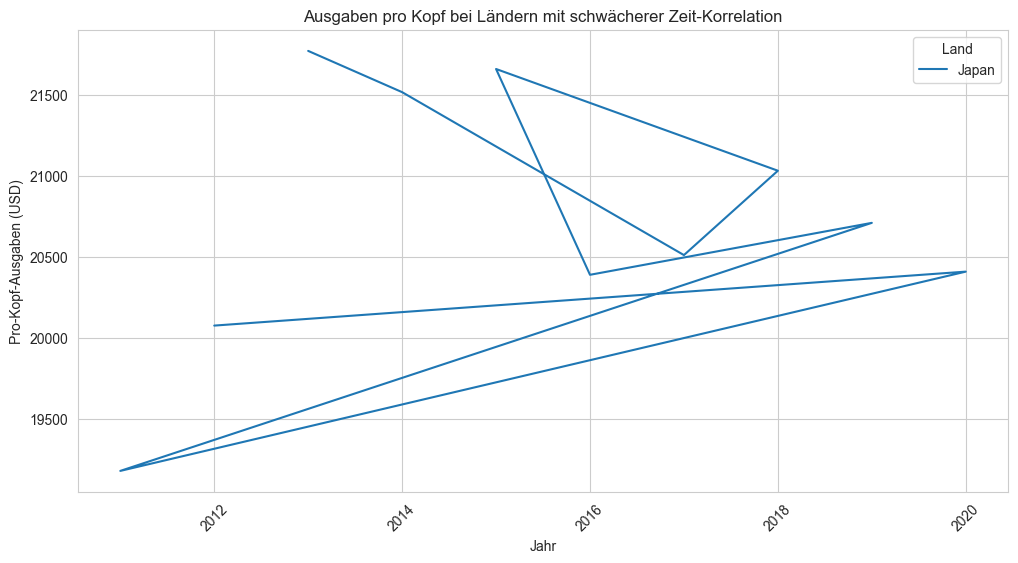

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Scatter Plot für die Haushaltsausgaben pro Kopf
plt.figure(figsize=(10, 6))
sns.scatterplot(data=Household_Spending, x="Year", y="Capita_Spending")
plt.xticks(Household_Spending["Year"].unique())
plt.yticks(range(0, 50001, 5000))
plt.title("Punktewolke für die Haushaltsausgaben pro Kopf")
plt.xlabel("Jahr")
plt.ylabel("Ausgaben pro Kopf USD")
plt.show()

# Mittelwerte je Land berechnen
mean_HS = Household_Spending[Household_Spending["Country"] != "Germany"].groupby("Year")["Capita_Spending"].mean().reset_index()
mean_HS.columns = ["Year", "mean_spending"]

# Linienplot für die Entwicklung der Haushaltsausgaben
plt.figure(figsize=(10, 6))
sns.lineplot(data=Household_Spending[Household_Spending["Country"] == "Germany"], x="Year", y="Capita_Spending", color="#1874CD", label="Deutschland")
sns.lineplot(data=mean_HS, x="Year", y="mean_spending", color="darkgreen", label="Durchschnitt")
plt.xticks(Household_Spending["Year"].unique())
plt.yticks(range(0, 30001, 2000))
plt.title("Entwicklung der Haushaltsausgaben 2011–2020")
plt.xlabel("Jahr")
plt.ylabel("Ausgaben pro Kopf in USD")
plt.legend(title="Linien: ")
plt.show()

# Mittelwerte für Breitbandzugang berechnen
mean_BB = Broadband_Access_90.groupby("Year")["Percentage_Households"].mean().reset_index()
mean_BB.columns = ["Year", "mean_access"]

# Scatter Plot für Haushalte mit Breitbandzugang
plt.figure(figsize=(10, 6))
sns.scatterplot(data=Broadband_Access_90, x="Year", y="Percentage_Households")
sns.lineplot(data=mean_BB, x="Year", y="mean_access", color="black")
plt.xticks(Broadband_Access_90["Year"].unique())
plt.yticks(range(0, 101, 10))
plt.title("Punktewolke für Haushalte mit Breitbandzugang")
plt.xlabel("Jahr")
plt.ylabel("Haushalte in %")
plt.show()

# Mittelwerte je Land berechnen
mean_by_country = Broadband_Access.groupby("Country")["Percentage_Households"].mean().reset_index()
mean_by_country.columns = ["Country", "mean_bb_C"]

mean_hs_C = Household_Spending.groupby("Country")["Capita_Spending"].mean().reset_index()
mean_hs_C.columns = ["Country", "mean_hs_C"]

mean_by_country = pd.merge(mean_by_country, mean_hs_C, on="Country")

# Korrelation berechnen
corr, p_value = pearsonr(mean_by_country["mean_bb_C"], mean_by_country["mean_hs_C"])
print(f"Korrelation: {corr}, p-Wert: {p_value}")

# Korrelation auf Länderebene plotten
plt.figure(figsize=(10, 6))
sns.regplot(data=mean_by_country, x="mean_bb_C", y="mean_hs_C", scatter_kws={"color": "#1874CD", "s": 25}, line_kws={"color": "black"})
plt.title("Korrelation auf Länderebene")
plt.xlabel("Breitbandzugang in %")
plt.ylabel("Ausgaben-pro-Kopf USD")
plt.show()

# Korrelation mit der Zeit berechnen
Household_cor_by_Land = Household_Spending.groupby("Country").apply(lambda x: x[["Capita_Spending", "Year"]].corr().iloc[0, 1]).reset_index()
Household_cor_by_Land.columns = ["Country", "cor_Capita_Spending_Year"]

Broadband_cor_by_Land = Broadband_Access_90.groupby("Country").apply(lambda x: x[["Percentage_Households", "Year"]].corr().iloc[0, 1]).reset_index()
Broadband_cor_by_Land.columns = ["Country", "cor_percentage_households"]

# Daten kombinieren und sortieren
correlations_combined = pd.merge(Household_cor_by_Land, Broadband_cor_by_Land, on="Country")
correlations_combined = correlations_combined.sort_values(by="cor_Capita_Spending_Year", ascending=False)

# Daten für den Balkenplot vorbereiten
correlations_combined_long = pd.melt(correlations_combined, id_vars=["Country"], value_vars=["cor_Capita_Spending_Year", "cor_percentage_households"])
correlations_combined_long.columns = ["Country", "Indikator", "Korrelation"]
correlations_combined_long["Indikator"] = correlations_combined_long["Indikator"].map({
    "cor_Capita_Spending_Year": "rxy_Haushaltsausgaben",
    "cor_percentage_households": "rxy_Breitbandzugang"
})

# Balkenplot für die Korrelationen
plt.figure(figsize=(12, 6))
sns.barplot(data=correlations_combined_long, x="Country", y="Korrelation", hue="Indikator", palette={"rxy_Haushaltsausgaben": "#1F77B4", "rxy_Breitbandzugang": "#FF7F0E"})
plt.xticks(rotation=35, ha="right")
plt.ylim(0, 1)
plt.yticks(range(0, 11, 1))
plt.title("Korrelation mit der Zeit")
plt.subplot(111).set_title("Sortiert nach Korrelationskoeffizient der Haushaltsausgaben", loc="center", fontsize=12)
plt.xlabel("")
plt.ylabel("Korrelationskoeffizient (rxy)")
plt.legend(title=None)
plt.show()

# Länder mit schwächerer Zeit-Korrelation identifizieren
suspicious_country = Household_cor_by_Land[Household_cor_by_Land["cor_Capita_Spending_Year"] <= 0.50]["Country"]

# Plot für Länder mit schwächerer Zeit-Korrelation
if not suspicious_country.empty:
    plt.figure(figsize=(12, 6))
    for country in suspicious_country:
        country_data = Household_Spending[Household_Spending["Country"] == country]
        plt.plot(country_data["Year"], country_data["Capita_Spending"], label=country)
    plt.xticks(rotation=45)
    plt.title("Ausgaben pro Kopf bei Ländern mit schwächerer Zeit-Korrelation")
    plt.xlabel("Jahr")
    plt.ylabel("Pro-Kopf-Ausgaben (USD)")
    plt.legend(title="Land")
    plt.show()
else:
    print("Keine Länder mit schwächerer Zeit-Korrelation gefunden.")


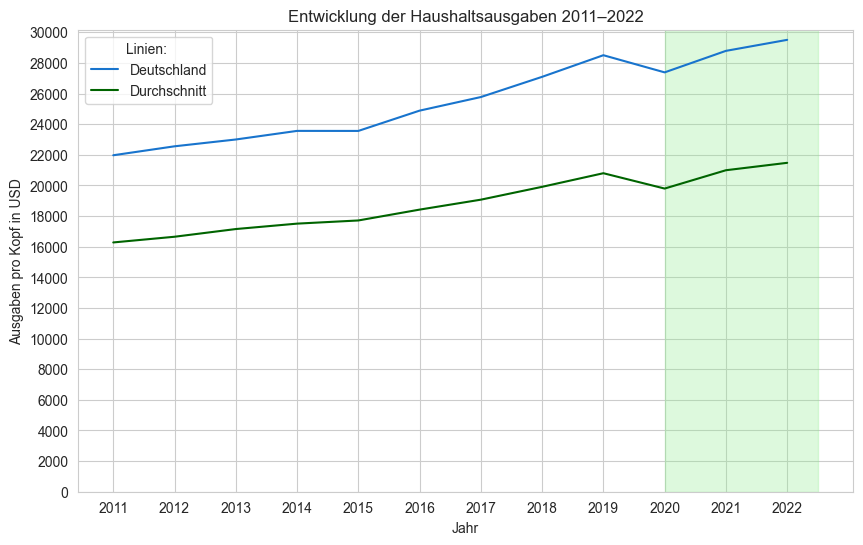

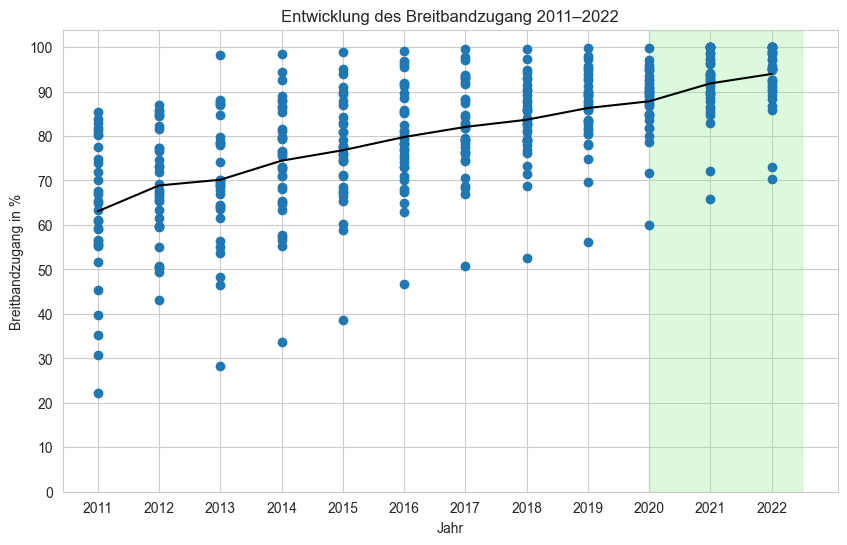

TypeError: can't multiply sequence by non-int of type 'float'

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Neue Jahre für Prognosen
zukunft = pd.DataFrame({"Year": [2021, 2022]})

# Prognose für Haushaltsausgaben
prognosis_list = []
for country, group in Household_Spending.groupby("Country"):
    # Entferne NaN-Werte
    group = group.dropna(subset=["Capita_Spending"])
    if len(group) > 1:  # Mindestens zwei Datenpunkte benötigt für die Regression
        model = LinearRegression().fit(group[["Year"]], group["Capita_Spending"])
        predictions = model.predict(zukunft)
        prognosis_df = pd.DataFrame({
            "Country": country,
            "Year": zukunft["Year"],
            "Capita_Spending": predictions
        })
        prognosis_list.append(prognosis_df)

Household_Spending_prognosis = pd.concat(prognosis_list, ignore_index=True)

# Originaldaten + Prognosen zusammenführen
Household_Spending_2022 = pd.concat([Household_Spending, Household_Spending_prognosis]).sort_values(by=["Country", "Year"])

# Mittelwerte für 2022 berechnen
mean_2022 = Household_Spending_2022[Household_Spending_2022["Country"] != "Germany"].groupby("Year")["Capita_Spending"].mean().reset_index()

# Plot für die Entwicklung der Haushaltsausgaben
plt.figure(figsize=(10, 6))
plt.axvspan(2020, 2022.5, color="lightgreen", alpha=0.3)
plt.plot(Household_Spending_2022[Household_Spending_2022["Country"] == "Germany"]["Year"],
         Household_Spending_2022[Household_Spending_2022["Country"] == "Germany"]["Capita_Spending"],
         color="#1874CD", label="Deutschland")
plt.plot(mean_2022["Year"], mean_2022["Capita_Spending"], color="darkgreen", label="Durchschnitt")
plt.xticks(Household_Spending_2022["Year"].unique())
plt.yticks(range(0, 30001, 2000))
plt.title("Entwicklung der Haushaltsausgaben 2011–2022")
plt.xlabel("Jahr")
plt.ylabel("Ausgaben pro Kopf in USD")
plt.legend(title="Linien: ")
plt.show()

# Prognose für Breitbandzugang
prognosis_list_BB = []
for country, group in Broadband_Access_90.groupby("Country"):
    # Entferne NaN-Werte
    group = group.dropna(subset=["Percentage_Households"])
    if len(group) > 1:  # Mindestens zwei Datenpunkte benötigt für die Regression
        model = LinearRegression().fit(group[["Year"]], group["Percentage_Households"])
        predictions = model.predict(zukunft)
        prognosis_df_BB = pd.DataFrame({
            "Country": country,
            "Year": zukunft["Year"],
            "Percentage_Households": np.minimum(predictions, 100)
        })
        prognosis_list_BB.append(prognosis_df_BB)

Broadband_Access_prognosis = pd.concat(prognosis_list_BB, ignore_index=True)

# Originaldaten + Prognosen zusammenführen
Broadband_Access_2022 = pd.concat([Broadband_Access_90, Broadband_Access_prognosis]).sort_values(by=["Country", "Year"])

# Mittelwerte für 2022 berechnen
mean_2022_BB = Broadband_Access_2022.groupby("Year")["Percentage_Households"].mean().reset_index()

# Plot für die Entwicklung des Breitbandzugangs
plt.figure(figsize=(10, 6))
plt.axvspan(2020, 2022.5, color="lightgreen", alpha=0.3)
plt.scatter(Broadband_Access_2022["Year"], Broadband_Access_2022["Percentage_Households"])
plt.plot(mean_2022_BB["Year"], mean_2022_BB["Percentage_Households"], color="black")
plt.xticks(Broadband_Access_2022["Year"].unique())
plt.yticks(range(0, 101, 10))
plt.title("Entwicklung des Breitbandzugang 2011–2022")
plt.xlabel("Jahr")
plt.ylabel("Breitbandzugang in %")
plt.show()

# Übersicht der Prognosen
Übersicht_Prognosen = pd.merge(
    Household_Spending_prognosis,
    Broadband_Access_prognosis,
    on=["Country", "Year"]
).round(2)

# Speichern der Übersicht als CSV
Übersicht_Prognosen.to_csv("Übersicht_Prognosen.csv", index=False)

# Berechnungen für die Marktwirkung
D = Household_Spending[(Household_Spending["Country"] == "Germany") & (Household_Spending["Year"] == 2019)]["Capita_Spending"].values[0]

Price = Household_Spending[Household_Spending["Year"] == 2019].copy()
Price = Price.dropna(subset=["Capita_Spending"])  # Entferne NaN-Werte
Price["rel_diff"] = Price["Capita_Spending"] / D
Price["est_price"] = np.ceil(Price["rel_diff"] * 12)
Price = Price.sort_values(by="est_price", ascending=False)[["Country", "Year", "rel_diff", "est_price"]]

# Haushaltsgrößen berechnen
haushalte = pd.DataFrame({
    "Country": ["United States", "Canada", "Mexico", "Australia", "Switzerland"],
    "Year": [2019, 2019, 2020, 2016, 2018],
    "Household_Size": [2.55, 2.54, 3.6, 2.5, 2.23]
})
haushalte = pd.merge(haushalte, Population, on=["Country", "Year"])
haushalte["household_size"] = (haushalte["Total_Population"] / haushalte["Household_Size"]) / 1000
haushalte = haushalte[["Country", "Year", "household_size"]]

# Daten kombinieren
Haushaltsgroeße_ext = pd.concat([Haushaltsgroeße, haushalte[["Year", "Country", "household_size"]]])

# Aktualisierte Breitbandzugangsdaten
Broadband_Access_latest = pd.merge(Broadband_Access, Haushaltsgroeße_ext, on=["Country", "Year"]).dropna()
Broadband_Access_latest = Broadband_Access_latest[Broadband_Access_latest["Year"] == 2019]

# Kandidaten für die Marktwirkung berechnen
Candidates = pd.merge(Household_Spending, Broadband_Access_latest, on=["Country", "Year"])
Candidates = Candidates.dropna(subset=["Capita_Spending", "Percentage_Households"])  # Entferne NaN-Werte
Candidates["rel_diff"] = np.round(Candidates["Capita_Spending"] / D, 2)
Candidates["households"] = (Candidates["household_size"] * 1000) * (Candidates["Percentage_Households"] / 100)
HPD = Candidates[Candidates["Country"] == "Germany"]["households"].values[0]
Candidates["rel_population_h"] = np.round(Candidates["households"] / HPD, 2)
Candidates["gew_score"] = np.round(Candidates["rel_diff"] * Candidates["rel_population_h"], 2)
Candidates = Candidates.sort_values(by="gew_score", ascending=False)[["Country", "Year", "rel_diff", "rel_population_h", "gew_score"]]

# Top 11 Länder nach gewichtetem Score
top11 = Candidates.head(11)[["Country", "gew_score"]]

# Plot für die Top 11 Länder
plt.figure(figsize=(10, 6))
sns.barplot(data=top11, x="gew_score", y="Country", palette=["#377EB8"])
plt.title("Top 10 Länder nach gewichteter Marktwirkung")
plt.subtitle("Score = Preisniveau × Haushaltsreichweite\n(Multiplikator im Vergleich zu Deutschland)")
plt.xlabel("Gewichteter Score")
plt.show()


In [ ]:
# Define D (replace with actual value)
D = 1

# Ensure Germany exists in the dataset
if "Germany" in Candidates["Country"].values:
    HPD = Candidates[Candidates["Country"] == "Germany"]["households"].values[0]
else:
    HPD = 1  # Default value or handle appropriately

# Calculate relative population and weighted score
Candidates["rel_diff"] = np.round(Candidates["Capita_Spending"] / D, 2)
Candidates["rel_population_h"] = np.round(Candidates["households"] / HPD, 2)
Candidates["gew_score"] = np.round(Candidates["rel_diff"] * Candidates["rel_population_h"], 2)
Candidates = Candidates.sort_values(by="gew_score", ascending=False)[["Country", "Year", "rel_diff", "rel_population_h", "gew_score"]]

# Top 11 countries by weighted score
top11 = Candidates.head(11)[["Country", "gew_score"]]

# Plot for the top 11 countries
plt.figure(figsize=(10, 6))
sns.barplot(data=top11, x="gew_score", y="Country", palette=["#377EB8"])
plt.title("Top 10 Länder nach gewichteter Marktwirkung")
plt.suptitle("Score = Preisniveau × Haushaltsreichweite\n(Multiplikator im Vergleich zu Deutschland)")
plt.xlabel("Gewichteter Score")
plt.show()

In [ ]:
# Define D (replace with actual value)
D = 1

# Ensure Germany exists in the dataset
if "Germany" in Candidates["Country"].values:
    HPD = Candidates[Candidates["Country"] == "Germany"]["households"].values[0]
else:
    HPD = 1  # Default value or handle appropriately

# Calculate relative population and weighted score
Candidates["rel_diff"] = np.round(Candidates["Capita_Spending"] / D, 2)
Candidates["rel_population_h"] = np.round(Candidates["households"] / HPD, 2)
Candidates["gew_score"] = np.round(Candidates["rel_diff"] * Candidates["rel_population_h"], 2)
Candidates = Candidates.sort_values(by="gew_score", ascending=False)[["Country", "Year", "rel_diff", "rel_population_h", "gew_score"]]

# Top 11 countries by weighted score
top11 = Candidates.head(11)[["Country", "gew_score"]]

# Plot for the top 11 countries
plt.figure(figsize=(10, 6))
sns.barplot(data=top11, x="gew_score", y="Country", palette=["#377EB8"])
plt.title("Top 10 Länder nach gewichteter Marktwirkung")
plt.suptitle("Score = Preisniveau × Haushaltsreichweite\n(Multiplikator im Vergleich zu Deutschland)")
plt.xlabel("Gewichteter Score")
plt.show()